In [1]:
# Import Libraries
import numpy as np
import torch
import torchvision.transforms as tvt
import torch.utils.data 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pprint import pprint
import time
import datetime
import gzip
import gensim.downloader as gen_api # free open-source Python library for representing documents as semantic vectors
from gensim.models import KeyedVectors
import pickle
import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/home/dfarache/.conda/envs/cent7/2020.11-py38/eceDL2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global Variables
train_dir = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw08/sentiment_dataset_train_400.tar.gz"
test_dir = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw08/sentiment_dataset_test_400.tar.gz"
path_to_model = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw08/model"
path_to_results = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw08/results"
path_to_saved_embeddings = r"/scratch/gilbreth/dfarache/ece60146/Nikita/hw08/word2vec"
batch_size = 1
num_layers = 1
classes = ('negative','positive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is on {device}")
device = torch.device(device)

Torch is on cuda


## Generate Datasets

In [3]:
class GenerateDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, embedding_path):
        super(GenerateDataset, self).__init__()
        self.data_path = data_path
        self.embedding_path = embedding_path

        self.get_word_vectors()
        self.get_sentiment_dataset()
    
    def get_word_vectors(self):
        if(os.path.exists(os.path.join(self.embedding_path, "vectors.kv"))):
            self.word_vectors = KeyedVectors.load(os.path.join(self.embedding_path, "vectors.kv"))
        else:
            print("Downloading Word2Vec Embeddings")
            self.word_vectors = gen_api.load("word2vec-google-news-300")
            self.word_vectors.save(os.path.join(self.embedding_path, "vectors.kv"))
    
    def __unzip_datasets(self):
        fptr = gzip.open(self.data_path, mode="rb")
        return fptr.read()

    def __get_indexed_dataset(self):
        self.indexed_dataset = []
        for category in self.positive_reviews:
            for review in self.positive_reviews[category]:
                self.indexed_dataset.append([review, category, 1])

        for category in self.negative_reviews:
            for review in self.negative_reviews[category]:
                self.indexed_dataset.append([review, category, 0])
        
        random.shuffle(self.indexed_dataset)

    def get_sentiment_dataset(self):
        dataset = self.__unzip_datasets()
        self.positive_reviews, self.negative_reviews, self.vocab = pickle.loads(dataset, encoding="latin1")

        self.categories = sorted(list(self.positive_reviews.keys()))
        self.positive_category_frequency = {category: len(self.positive_reviews[category]) for category in self.categories}
        self.negative_category_frequency = {category: len(self.negative_reviews[category]) for category in self.categories}
        self.__get_indexed_dataset()

    def review_to_tensor(self, review):
        list_of_embeddings = []
        for idx, word in enumerate(review):
            if(word in self.word_vectors.key_to_index):
                embedding = self.word_vectors[word]
                list_of_embeddings.append(np.array(embedding))
            else: next
        review_tensor = torch.tensor(list_of_embeddings, dtype=torch.float)
        return review_tensor
    
    def sentiment_to_tensor(self, sentiment):
        sentiment_tensor = torch.zeros(2)
        if(sentiment):
            sentiment_tensor[1] = 1
        else:
            sentiment_tensor[0] = 1
        sentiment_tensor = sentiment_tensor.type(torch.long)
        return sentiment_tensor
    
    def __len__(self):
        return len(self.indexed_dataset)
    
    def __getitem__(self, idx):
        sample = self.indexed_dataset[idx]
        review, category, sentiment = sample
        review_tensor = self.review_to_tensor(review) # Shape of review tensor: (number of words found in word2vec x length of word2vec)
        sentiment_tensor = self.sentiment_to_tensor(sentiment) # Shape of sentiment tensor: (1x2)
        category_idx = self.categories.index(category)
        return {"review": review_tensor, "category": category_idx, "sentiment": sentiment_tensor}

In [4]:
def generate_dataloader(data_path, embedding_path, debug=False):
    dataset = GenerateDataset(data_path, embedding_path)
    if(debug):
        pprint(dataset[2])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    return dataloader

trainloader = generate_dataloader(train_dir, path_to_saved_embeddings, debug=True)
testloader = generate_dataloader(test_dir, path_to_saved_embeddings)

{'category': 13,
 'review': tensor([[-0.2256, -0.0195,  0.0908,  ...,  0.0282, -0.1777, -0.0060],
        [ 0.0571, -0.0527, -0.1172,  ..., -0.0444,  0.0138, -0.0381],
        [ 0.1094,  0.1406, -0.0317,  ...,  0.0077,  0.1201, -0.1797],
        ...,
        [ 0.0081,  0.2578,  0.2471,  ..., -0.3359,  0.0322, -0.0698],
        [ 0.0801,  0.1050,  0.0498,  ...,  0.0037,  0.0476, -0.0688],
        [ 0.1416, -0.0271, -0.1846,  ...,  0.0143,  0.1484, -0.0383]]),
 'sentiment': tensor([0, 1])}


## Network

### Task 1

In [5]:
class GRUCell(nn.Module):
    # Inspired by https://github.com/georgeyiasemis/Recurrent-Neural-Networks-from-scratch-using-PyTorch/blob/main/rnnmodels.py
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        self.Z = nn.Linear(in_features=self.input_size, out_features=3*self.hidden_size, bias=self.bias)
        self.U = nn.Linear(in_features=self.hidden_size, out_features=3*self.hidden_size, bias=self.bias)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
            
    def forward(self, X, hidden_state=None):
        if(hidden_state is None):
            hidden_state = torch.zeros((batch_size, self.hidden_size), device=device, dtype=X.dtype, requires_grad=True)
        
        Z_t = self.Z(X)
        U_t = self.U(hidden_state)
        
        """
        Similar to creating N nn.Linear layers and doing forward pass with all N of them, we can instead 
        create a single linear layer, do one forward pass and just chunk the output into N pieces
        """
        
        Wzx, Wrx, Whx = Z_t.chunk(3, dim=1)
        Uzx, Urx, Uhx = U_t.chunk(3, dim=1)
        
        reset_gate = F.sigmoid(Wrx + Urx)
        update_gate = F.sigmoid(Wzx + Uzx)
        candidate_hidden_gate = F.tanh(Whx + (reset_gate * Uhx))
        
        hidden_state = update_gate * hidden_state + (1 - update_gate) * candidate_hidden_gate
        return hidden_state

In [6]:
class GRU(nn.Module):
    # Inspired by https://github.com/georgeyiasemis/Recurrent-Neural-Networks-from-scratch-using-PyTorch/blob/main/rnnmodels.py
    def __init__(self, input_size, hidden_size, output_size, num_layers, bias):
        super(GRU, self).__init__()
        self.input_size = input_size # Size of the tensor for each word in a sequence of words. Since we are using the word2vec embedding, the value of this variable will always be 300
        self.hidden_size = hidden_size # Size of the hidden state in the RNN
        self.output_size = output_size # Output of the RNN, in this case will be 2 (positive, negative)
        self.num_layers = num_layers # Create a stack of GRUs
        self.bias = bias
        
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list.append(GRUCell(self.input_size, self.hidden_size, self.bias))
        self.logSoftMax = nn.LogSoftmax()
        
        for layer in range(1, self.num_layers):
            self.rnn_cell_list.append(GRUCell(self.input_size, self.hidden_size, self.bias))
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, inputs, hidden_state=None):
        if(hidden_state is None):
            hidden_state = torch.zeros((self.num_layers, batch_size, self.hidden_size), device=device, dtype=inputs.dtype, requires_grad=True)
        
        outputs = []
        hidden = []
        for layer in range(self.num_layers):
            hidden.append(hidden_state[layer, :, :])
        
        for seq in range(inputs.shape[1]):
            for layer in range(self.num_layers):
                if(not layer):
                    hidden_layer = self.rnn_cell_list[layer](inputs[:, seq, :], hidden[layer])
                else:
                    hidden_layer = self.rnn_cell_list[layer](hidden[layer - 1], hidden[layer])
                hidden[layer] = hidden_layer
                
            outputs.append(hidden_layer)
        
        final_hidden_layer = outputs[-1]
        final_hidden_layer = self.fc(final_hidden_layer)
        final_hidden_layer = self.logSoftMax(final_hidden_layer)
        return final_hidden_layer

In [7]:
# Number of layers and learnable parameters in the GRU Network
model = GRU(input_size=300, hidden_size=100, output_size=2, num_layers=num_layers, bias=True)
num_layers_in_model = len(list(model.parameters()))
num_learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of layers in the GRU with Embeddings network: {num_layers_in_model}")
print(f"Number of learnable parameters in the GRU with Embeddings network: {num_learnable_parameters}")

Number of layers in the GRU with Embeddings network: 6
Number of learnable parameters in the GRU with Embeddings network: 120802


### Task 2

In [8]:
class GRUnetWithEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bidirectional=False):
        # Inspired by Professor Kak's GRUnetWithEmbedding
        super(GRUnetWithEmbedding, self).__init__()
        self.input_size = input_size # Size of the tensor for each word in a sequence of words. Since we are using the word2vec embedding, the value of this variable will always be 300
        self.hidden_size = hidden_size # Size of the hidden state in the RNN
        self.output_size = output_size # Output of the RNN, in this case will be 2 (positive, negative)
        self.num_layers = num_layers # Create a stack of GRUs
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, bidirectional=self.bidirectional, batch_first=True)
        
        self.num_bidirectional = 2 if self.bidirectional else 1
        self.fc = nn.Linear(in_features=self.hidden_size * self.num_layers * self.num_bidirectional, out_features=self.output_size)
        self.logSoftMax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(F.relu(out[:, -1]))
        out = self.logSoftMax(out)
        return out, h
    
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new_zeros((num_layers * self.num_bidirectional, batch_size, self.hidden_size)) # create a new tensor of the same datatype filled with zeros - useful when we don't know what the priori datatype is
        return hidden

In [9]:
# Number of layers and learnable parameters in the GRUnetWithEmbedding Network
model = GRUnetWithEmbedding(input_size=300, hidden_size=100, output_size=2, num_layers=num_layers)
num_layers_in_model = len(list(model.parameters()))
num_learnable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of layers in the GRU with Embeddings network: {num_layers_in_model}")
print(f"Number of learnable parameters in the GRU with Embeddings network: {num_learnable_parameters}")

Number of layers in the GRU with Embeddings network: 6
Number of learnable parameters in the GRU with Embeddings network: 120802


## Training and Testing

In [10]:
def plot_losses(loss, epochs, mode="scratch"):
    # Plot the training losses
    iterations = range(len(loss))
    plt.plot(iterations, loss)
    
    plt.title("Training Loss")
    plt.xlabel(f"Iterations over {epochs} epochs")
    plt.ylabel("Loss")
    plt.legend(loc ="upper right")
    
    filename = "train_loss_" + mode + ".jpg"
    plt.savefig(os.path.join(path_to_results, filename))
    plt.show()

In [11]:
def train(trainloader, criterion, lr, betas, epochs, log=200, task=1, bidirectional=False):
    
    if(task==1):
        net = GRU(input_size=300, hidden_size=100, output_size=2, num_layers=1, bias=True)
    elif(task==2):
        net = GRUnetWithEmbedding(input_size=300, hidden_size=100, output_size=2, num_layers=num_layers, bidirectional=bidirectional)
    
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=betas) # Adam Optimizer
    net = net.to(device)
    training_loss = []

    print(f"Training started at time {datetime.datetime.now().time()}")
    start_time = time.time()
    check_loss = float("inf")
    
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for batch_idx, data in enumerate(trainloader):
            review, category, sentiment = data["review"], data["category"], data["sentiment"]
            
            review = review.to(device)
            category = category.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            if(task==1):
                output = net(review)
            elif(task==2):
                output, hidden = net(review, net.init_hidden().to(device))
            
            loss = criterion(output, torch.argmax(sentiment, dim=1))
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if batch_idx % log == log-1:    
                average_loss = running_loss / float(log)
                training_loss.append(average_loss)
                current_time = time.time()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch, batch_idx+1, time_elapsed, average_loss))
                
                if(running_loss < check_loss):
                    check_loss = running_loss
                    bidirectional_name = "bid" if bidirectional else "no_bid"
                    torch.save(net.state_dict(), os.path.join(path_to_model, "Task " + str(task) + "_" + bidirectional_name + ".pt"))

                running_loss = 0.0
    
    print("Lowest loss achieved by network: %.4f" % (check_loss / float(log)))
    print("Training finished in %4d secs" % (time.time() - start_time))
    return net, training_loss            

In [12]:
def test(net, testloader, log=100, task=1, bidirectional="no_bid"):
    model_name = "Task " + str(task) + "_" + bidirectional + ".pt"
    net.load_state_dict(torch.load(os.path.join(path_to_model, model_name)))
    net = net.to(device)
    confusion_matrix = np.zeros((len(classes), len(classes)))

    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            review, category, sentiment = data["review"], data["category"], data["sentiment"]
            review = review.to(device)
            category = category.to(device)
            sentiment = sentiment.to(device)
            
            if(task==1):
                output = net(review)
            elif(task==2):
                output, hidden = net(review, net.init_hidden().to(device))
            
            predicted_idx = torch.argmax(output).item()
            gt_idx = torch.argmax(sentiment).item()

            if(batch_idx % log == log - 1):
                print("   [batch_idx=%d]    predicted_label=%d       gt_label=%d" % (batch_idx+1, predicted_idx, gt_idx))   
            confusion_matrix[gt_idx, predicted_idx] += 1

    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    return confusion_matrix, accuracy

In [13]:
def display_confusion_matrix(conf, accuracy, class_list=classes, task=1, bidirectional="no_bid"):
    figure = plt.figure(3)
    sns.heatmap(conf, xticklabels=class_list, yticklabels=class_list, annot=True)
    plt.xlabel(f"True Label \n Accuracy: {accuracy}")
    plt.ylabel("Predicted Label")

    filename = "conf_" + str(task) + "_" + bidirectional + ".jpg"
    plt.savefig(os.path.join(path_to_results, filename))

## Task 1

### Training

In [14]:
# Parameters for training 
lr = 1e-4 # Learning Rate
betas = (0.9, 0.999) # Betas factor
epochs = 5 # Number of epochs to train
criterion = nn.NLLLoss() # Negative Log Likelihood Loss

Training started at time 19:13:21.302765
[epoch:1  iter: 800  elapsed_time:  92 secs]     loss: 0.68544
[epoch:1  iter:1600  elapsed_time: 180 secs]     loss: 0.65556
[epoch:1  iter:2400  elapsed_time: 269 secs]     loss: 0.58972
[epoch:1  iter:3200  elapsed_time: 362 secs]     loss: 0.54331
[epoch:1  iter:4000  elapsed_time: 453 secs]     loss: 0.54876
[epoch:1  iter:4800  elapsed_time: 546 secs]     loss: 0.50168
[epoch:1  iter:5600  elapsed_time: 639 secs]     loss: 0.52044
[epoch:1  iter:6400  elapsed_time: 733 secs]     loss: 0.50741
[epoch:1  iter:7200  elapsed_time: 824 secs]     loss: 0.47482
[epoch:1  iter:8000  elapsed_time: 918 secs]     loss: 0.50240
[epoch:1  iter:8800  elapsed_time:1010 secs]     loss: 0.49524
[epoch:1  iter:9600  elapsed_time:1101 secs]     loss: 0.49316
[epoch:1  iter:10400  elapsed_time:1187 secs]     loss: 0.49830
[epoch:1  iter:11200  elapsed_time:1284 secs]     loss: 0.47464
[epoch:1  iter:12000  elapsed_time:1377 secs]     loss: 0.48407
[epoch:1  i

No handles with labels found to put in legend.


Lowest loss achieved by network: 0.2876
Training finished in 8075 secs


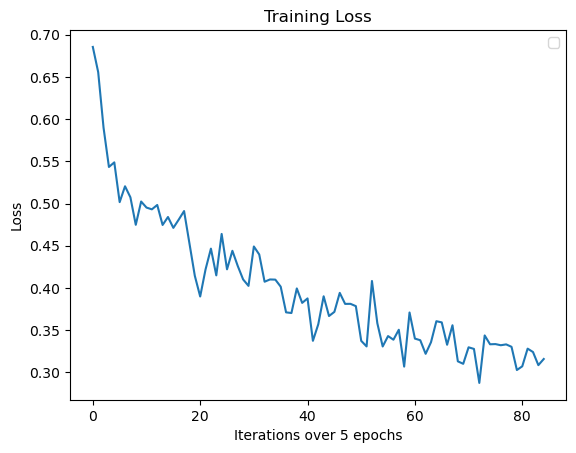

In [15]:
net1, training_loss = train(trainloader, criterion, lr, betas, epochs, log=800, task=1)
plot_losses(training_loss, epochs, mode="scratch")

### Testing

   [batch_idx=500]    predicted_label=1       gt_label=1
   [batch_idx=1000]    predicted_label=1       gt_label=1
   [batch_idx=1500]    predicted_label=1       gt_label=1
   [batch_idx=2000]    predicted_label=0       gt_label=0
   [batch_idx=2500]    predicted_label=1       gt_label=1
   [batch_idx=3000]    predicted_label=0       gt_label=0
   [batch_idx=3500]    predicted_label=1       gt_label=0


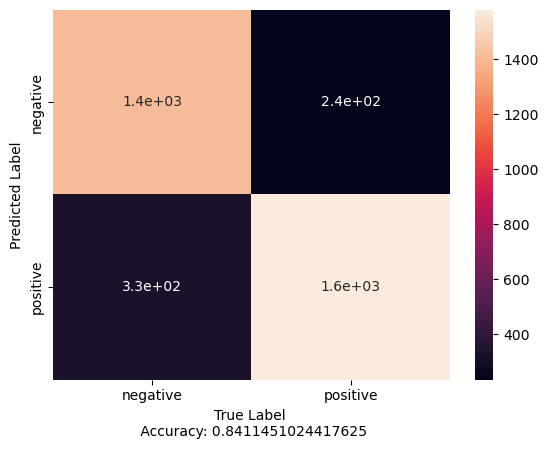

In [16]:
confusion_matrix, accuracy = test(net1, testloader, log=500, task=1, bidirectional="no_bid")
display_confusion_matrix(confusion_matrix, accuracy, task=1)

## Task 2

### Without Bidirectional

#### Training

In [17]:
# Parameters for training 
lr = 1e-4 # Learning Rate
betas = (0.9, 0.999) # Betas factor
epochs = 5 # Number of epochs to train
criterion = nn.NLLLoss() # Negative Log Likelihood Loss

Training started at time 21:29:15.033771
[epoch:1  iter: 800  elapsed_time:   4 secs]     loss: 0.68759
[epoch:1  iter:1600  elapsed_time:   8 secs]     loss: 0.67777
[epoch:1  iter:2400  elapsed_time:  12 secs]     loss: 0.67158
[epoch:1  iter:3200  elapsed_time:  17 secs]     loss: 0.60928
[epoch:1  iter:4000  elapsed_time:  21 secs]     loss: 0.53789
[epoch:1  iter:4800  elapsed_time:  25 secs]     loss: 0.52661
[epoch:1  iter:5600  elapsed_time:  30 secs]     loss: 0.50897
[epoch:1  iter:6400  elapsed_time:  34 secs]     loss: 0.52906
[epoch:1  iter:7200  elapsed_time:  38 secs]     loss: 0.49797
[epoch:1  iter:8000  elapsed_time:  42 secs]     loss: 0.54044
[epoch:1  iter:8800  elapsed_time:  46 secs]     loss: 0.48009
[epoch:1  iter:9600  elapsed_time:  51 secs]     loss: 0.47346
[epoch:1  iter:10400  elapsed_time:  56 secs]     loss: 0.45292
[epoch:1  iter:11200  elapsed_time:  60 secs]     loss: 0.50940
[epoch:1  iter:12000  elapsed_time:  65 secs]     loss: 0.47234
[epoch:1  i

No handles with labels found to put in legend.


Lowest loss achieved by network: 0.2710
Training finished in  388 secs


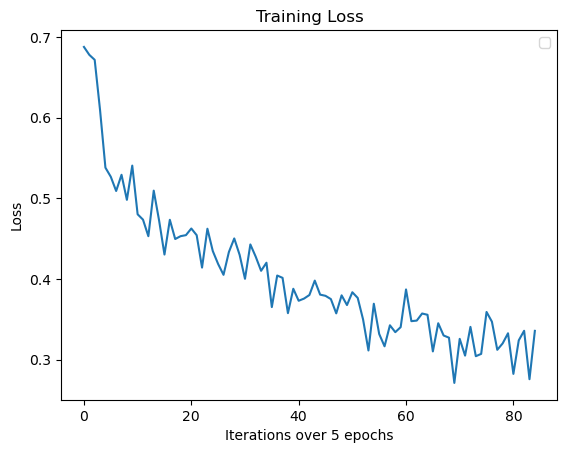

In [18]:
net2, training_loss = train(trainloader, criterion, lr, betas, epochs, log=800, task=2, bidirectional=False)
plot_losses(training_loss, epochs, mode="torch_nobid")

#### Testing

   [batch_idx=500]    predicted_label=1       gt_label=1
   [batch_idx=1000]    predicted_label=1       gt_label=1
   [batch_idx=1500]    predicted_label=0       gt_label=0
   [batch_idx=2000]    predicted_label=0       gt_label=0
   [batch_idx=2500]    predicted_label=0       gt_label=0
   [batch_idx=3000]    predicted_label=0       gt_label=0
   [batch_idx=3500]    predicted_label=0       gt_label=1


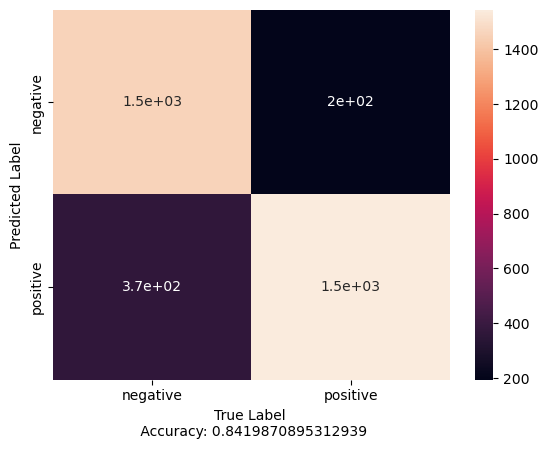

In [19]:
confusion_matrix, accuracy = test(net2, testloader, log=500, task=2, bidirectional="no_bid")
display_confusion_matrix(confusion_matrix, accuracy, task=2)

### With Bidirectional

#### Training

In [20]:
# Parameters for training 
lr = 1e-4 # Learning Rate
betas = (0.9, 0.999) # Betas factor
epochs = 5 # Number of epochs to train
criterion = nn.NLLLoss() # Negative Log Likelihood Loss

Training started at time 21:35:58.780608
[epoch:1  iter: 800  elapsed_time:   5 secs]     loss: 0.69086
[epoch:1  iter:1600  elapsed_time:  10 secs]     loss: 0.68022
[epoch:1  iter:2400  elapsed_time:  16 secs]     loss: 0.64880
[epoch:1  iter:3200  elapsed_time:  22 secs]     loss: 0.57599
[epoch:1  iter:4000  elapsed_time:  27 secs]     loss: 0.52899
[epoch:1  iter:4800  elapsed_time:  32 secs]     loss: 0.56169
[epoch:1  iter:5600  elapsed_time:  38 secs]     loss: 0.51305
[epoch:1  iter:6400  elapsed_time:  43 secs]     loss: 0.51645
[epoch:1  iter:7200  elapsed_time:  49 secs]     loss: 0.49933
[epoch:1  iter:8000  elapsed_time:  54 secs]     loss: 0.51417
[epoch:1  iter:8800  elapsed_time:  60 secs]     loss: 0.51097
[epoch:1  iter:9600  elapsed_time:  65 secs]     loss: 0.51736
[epoch:1  iter:10400  elapsed_time:  70 secs]     loss: 0.49400
[epoch:1  iter:11200  elapsed_time:  76 secs]     loss: 0.45961
[epoch:1  iter:12000  elapsed_time:  81 secs]     loss: 0.45388
[epoch:1  i

No handles with labels found to put in legend.


Lowest loss achieved by network: 0.2782
Training finished in  476 secs


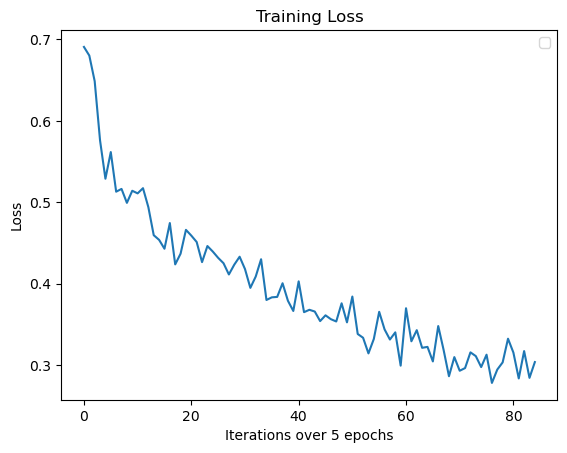

In [21]:
net2, training_loss = train(trainloader, criterion, lr, betas, epochs, log=800, task=2, bidirectional=True)
plot_losses(training_loss, epochs, mode="torch_bid")

#### Testing

   [batch_idx=500]    predicted_label=1       gt_label=1
   [batch_idx=1000]    predicted_label=1       gt_label=1
   [batch_idx=1500]    predicted_label=0       gt_label=0
   [batch_idx=2000]    predicted_label=0       gt_label=0
   [batch_idx=2500]    predicted_label=1       gt_label=1
   [batch_idx=3000]    predicted_label=1       gt_label=1
   [batch_idx=3500]    predicted_label=1       gt_label=1


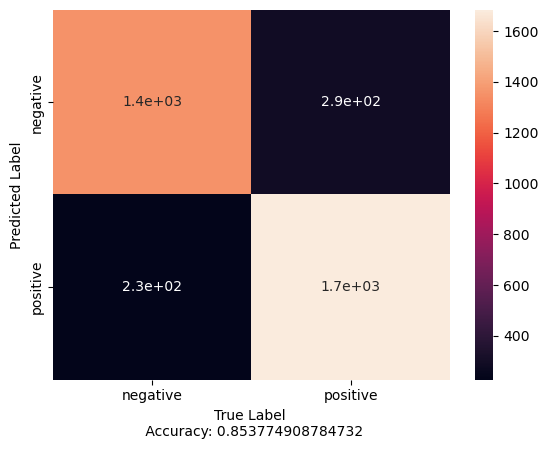

In [22]:
confusion_matrix, accuracy = test(net2, testloader, log=500, task=2, bidirectional="bid")
display_confusion_matrix(confusion_matrix, accuracy, task=2, bidirectional="bid")